In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
file_path = 'Tool path patterns.csv'
df = pd.read_csv(file_path)
df.head()

,i [-],d [mm],b [mm],teta [°],rmin [mm],y1-y5 [mm]
0,1,2,2.5,15,0.1,"{0.11558855506058881, 0.24719677777743024, 0.2..."
1,2,2,2.5,30,0.1,"{0.216761052598018, 0.3329000358149047, 0.3459..."
2,3,2,2.5,45,0.1,"{0.1499357349778388, 0.3068853828181764, 0.301..."
3,4,2,2.5,60,0.1,"{0.15559145879572533, 0.33675985954098275, 0.3..."
4,5,2,3.0,15,0.1,"{0.2028426089422255, 0.46336496036817393, 0.46..."


In [3]:
df.columns = [col.split(' ')[0] for col in df.columns]
df.head()

,i,d,b,teta,rmin,y1-y5
0,1,2,2.5,15,0.1,"{0.11558855506058881, 0.24719677777743024, 0.2..."
1,2,2,2.5,30,0.1,"{0.216761052598018, 0.3329000358149047, 0.3459..."
2,3,2,2.5,45,0.1,"{0.1499357349778388, 0.3068853828181764, 0.301..."
3,4,2,2.5,60,0.1,"{0.15559145879572533, 0.33675985954098275, 0.3..."
4,5,2,3.0,15,0.1,"{0.2028426089422255, 0.46336496036817393, 0.46..."


In [4]:
y_columns = df['y1-y5'].str.strip('{}').str.split(',', expand=True)
y_columns.columns = ['y1', 'y2', 'y3', 'y4', 'y5']
y_columns = y_columns.apply(pd.to_numeric)
df = pd.concat([df.drop(columns=['y1-y5']), y_columns], axis=1)
df.head()

,i,d,b,teta,rmin,y1,y2,y3,y4,y5
0,1,2,2.5,15,0.1,0.115589,0.247197,0.236927,0.156377,0.040423
1,2,2,2.5,30,0.1,0.216761,0.332900,0.345969,0.280819,0.163101
2,3,2,2.5,45,0.1,0.149936,0.306885,0.301498,0.261639,0.136204
3,4,2,2.5,60,0.1,0.155591,0.336760,0.317699,0.315193,0.168882
4,5,2,3.0,15,0.1,0.202843,0.463365,0.461673,0.265619,0.103552


In [5]:
X = df[['b', 'teta', 'rmin']].values
y = df[['y1', 'y2', 'y3', 'y4', 'y5']].values
X[:5], y[:5]

(array([[ 2.5, 15. ,  0.1],
        [ 2.5, 30. ,  0.1],
        [ 2.5, 45. ,  0.1],
        [ 2.5, 60. ,  0.1],
        [ 3. , 15. ,  0.1]]),
 array([[0.11558856, 0.24719678, 0.23692656, 0.15637668, 0.04042283],
        [0.21676105, 0.33290004, 0.34596909, 0.28081877, 0.16310109],
        [0.14993573, 0.30688538, 0.30149823, 0.26163933, 0.13620375],
        [0.15559146, 0.33675986, 0.31769936, 0.31519308, 0.16888184],
        [0.20284261, 0.46336496, 0.46167313, 0.26561944, 0.10355181]]))

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train, X_test


(array([[0.33333333, 0.        , 0.33333333],
        [0.        , 1.        , 0.        ],
        [0.33333333, 0.66666667, 0.        ],
        [1.        , 0.33333333, 0.33333333],
        [0.66666667, 0.66666667, 1.        ],
        [0.33333333, 0.33333333, 0.66666667],
        [0.33333333, 0.33333333, 1.        ],
        [1.        , 0.33333333, 0.66666667],
        [0.33333333, 1.        , 0.66666667],
        [0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.        , 1.        ],
        [0.66666667, 0.33333333, 0.66666667],
        [0.66666667, 0.33333333, 1.        ],
        [1.        , 0.66666667, 0.66666667],
        [0.        , 0.        , 0.        ],
        [0.66666667, 1.        , 0.66666667],
        [0.66666667, 0.66666667, 0.66666667],
        [0.33333333, 0.33333333, 0.        ],
        [0.33333333, 1.        , 0.33333333],
        [0.66666667, 1.        , 1.        ],
        [0.        , 0.33333333, 0.        ],
        [1.        , 0.66666667, 0

In [9]:
output_scaler = MinMaxScaler()
y_train = output_scaler.fit_transform(y_train)
y_test = output_scaler.transform(y_test)

In [10]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [11]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(3, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 5)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        return self.output_layer(x)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNetwork().to(device)

In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0015)

In [15]:
epochs = 100
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0302
Epoch [20/100], Loss: 0.0067
Epoch [30/100], Loss: 0.0034
Epoch [40/100], Loss: 0.0038
Epoch [50/100], Loss: 0.0008
Epoch [60/100], Loss: 0.0010
Epoch [70/100], Loss: 0.0018
Epoch [80/100], Loss: 0.0006
Epoch [90/100], Loss: 0.0005
Epoch [100/100], Loss: 0.0005


In [16]:
model.eval()
with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
    test_loss /= len(test_loader)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0008


In [ ]:
new_data = np.array([[5.0, 45.0, 0.3]])  # Test values 
new_data_scaled = scaler.transform(new_data)
new_data_tensor = torch.tensor(new_data_scaled, dtype=torch.float32).to(device)

with torch.no_grad(): 
    predictions = model(new_data_tensor)

predictions_list = predictions.squeeze().tolist()
predictions_original_scale = output_scaler.inverse_transform([predictions_list])

print("Predicted y1-y5:", predictions_list)
print("Predicted y1-y5 (original scale):", predictions_original_scale[0])

Predicted y1-y5: [1.2179057598114014, 1.3185319900512695, 1.2280347347259521, 1.1183868646621704, 0.8077242970466614]
Predicted y1-y5 (original scale): [0.60475524 1.40752961 1.35466658 1.08928682 0.5735453 ]


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# Eval mode
model.eval()

y_test_pred = []
y_test_actual = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        
        y_test_pred.extend(outputs.cpu().numpy())
        y_test_actual.extend(targets.cpu().numpy())

y_test_pred = np.array(y_test_pred)
y_test_actual = np.array(y_test_actual)

mae = mean_absolute_error(y_test_actual, y_test_pred)
r2 = r2_score(y_test_actual, y_test_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 0.0194
R² Score: 0.9741


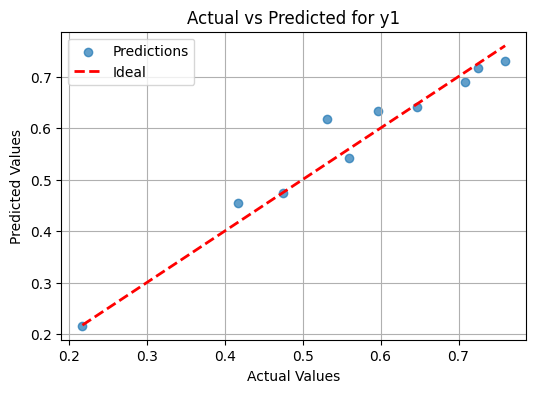

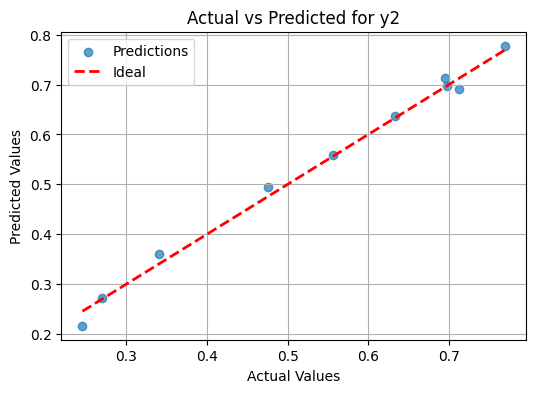

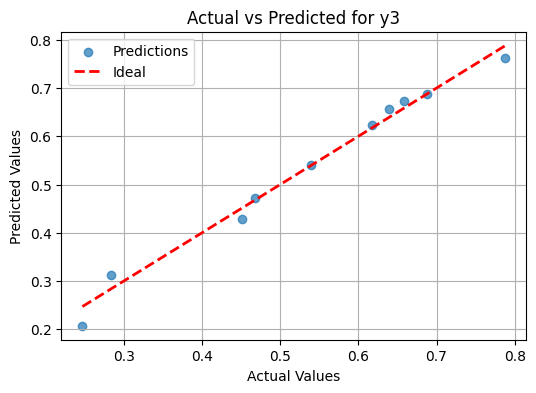

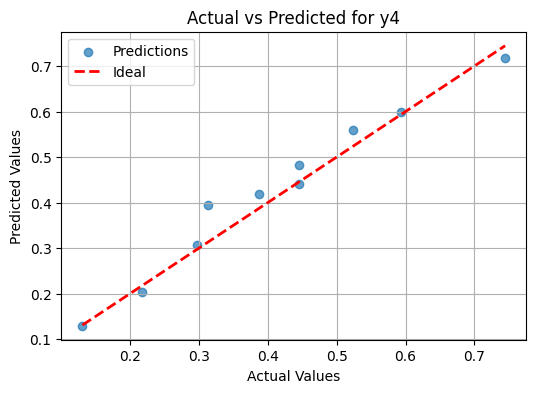

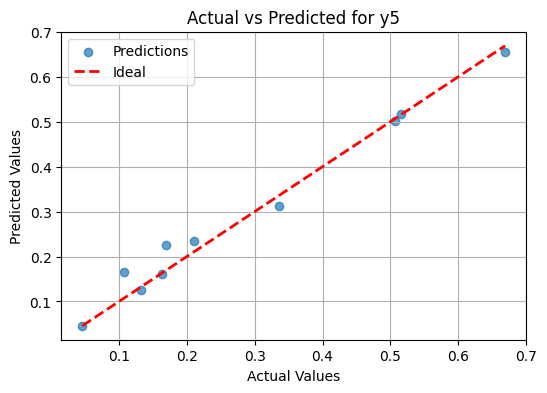

In [19]:
import matplotlib.pyplot as plt

for i in range(5):  
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test_actual[:, i], y_test_pred[:, i], alpha=0.7, label='Predictions')
    plt.plot([y_test_actual[:, i].min(), y_test_actual[:, i].max()],
             [y_test_actual[:, i].min(), y_test_actual[:, i].max()], 
             color='red', linestyle='--', linewidth=2, label='Ideal')
    plt.title(f'Actual vs Predicted for y{i+1}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid()
    plt.show()


In [20]:
from sklearn.model_selection import KFold

# K-Fold cross-validation
kf = KFold(n_splits=5)
fold = 1

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    
    scaler_fold = MinMaxScaler()
    X_train_fold = scaler_fold.fit_transform(X_train_fold)
    X_val_fold = scaler_fold.transform(X_val_fold)
    output_scaler_fold = MinMaxScaler()
    y_train_fold = output_scaler_fold.fit_transform(y_train_fold)
    y_val_fold = output_scaler_fold.transform(y_val_fold)
    
    X_train_tensor = torch.tensor(X_train_fold, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.float32).to(device)
    X_val_tensor = torch.tensor(X_val_fold, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val_fold, dtype=torch.float32).to(device)

    
    model = NeuralNetwork().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0015)
    criterion = nn.MSELoss()

    for epoch in range(20):  
        model.train()
        for inputs, targets in DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


    model.eval()
    val_loss = 0
    with torch.no_grad():
        outputs = model(X_val_tensor)
        val_loss = criterion(outputs, y_val_tensor).item()

    print(f"Fold {fold}, Validation Loss: {val_loss:.4f}")
    fold += 1


Fold 1, Validation Loss: 0.0684
Fold 2, Validation Loss: 0.0166
Fold 3, Validation Loss: 0.0056
Fold 4, Validation Loss: 0.0064
Fold 5, Validation Loss: 0.0178
